In [1]:
import wget
import zipfile
import re
import tqdm
import os
import numpy as np

from rdkit import Chem
from rdkit.Chem.Descriptors import MolWt
from rdkit.Chem.MolStandardize import rdMolStandardize
enumerator = rdMolStandardize.TautomerEnumerator()


import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
from pylab import cm


In [2]:
########################################################### FUNCTIONS BY ITERATIONS #######################################

def get_stable_tatuomer(Smiles):
    """ Get Sable Tautoer """
    tautomer = ""
    try:
        tautomer = Chem.CanonSmiles(Chem.MolToSmiles(enumerator.Canonicalize(Chem.MolFromSmiles(Smiles))))
    except:
        print(f"Could not find tatuomer for {Smiles}")
        
        
    return tautomer
    
def network_iterations(path,Tautomers=False):
    """ Generates a dictionary that saves molecules by Iteration"""
    Network = dict()    # Define an Empty Dictionary
    Loaded = 0          # Number of molecules loaded
    ### Open file with context handler ###
    with open(path, "r") as handler:
        for line in  handler:                     # Iterate over the lines
            try:
                iteration,smiles = line.split()      # Splite every line: The format is Iteration,moleule  e.g. G1    ccc1c3
                try:
                    if Tautomers:
                        CanonicalSmiles = get_stable_tatuomer(smiles)
                    else:   
                        CanonicalSmiles = Chem.CanonSmiles(smiles)
                except:
                    pass
                
                if CanonicalSmiles != "":
                    try:

                        Network[iteration].append(CanonicalSmiles) # Append molecule to iteration list inside Network dictionary
                        Loaded +=1

                    except:
                        Network[iteration] = list()           # If an exception occurs then iteration list does not exxists, create it
                        Network[iteration].append(CanonicalSmiles) # Append molecule to iteration list inside Network dictionary
                        Loaded +=1
            except:
                pass
    
    print(f"Iterations: {Network.values().__len__()}, Total Moleules: {Loaded}")
        
    return Network


                
def get_max_mass_iterations(Network):
    MaxMass = dict()                                                             # Initiate Dictioanry
    for Iteration,SmilesList in zip(Network.keys(),Network.values()):            # Iterate over Network
        Mass = max([MolWt(Chem.MolFromSmiles(Smiles)) for Smiles in SmilesList]) # Get Maximum mass at each iteration
        MaxMass[Iteration] = Mass                                                # Append it to dictionary
        print(f"Max Molecular Weight for iteration {Iteration}: {Mass}")
        
    
    return MaxMass

###################################################### Functions without database iterations

def database(path,MaxMass,Tautomers=False):
    """ Generates a list that saves smiles strings """
    Ignored = 0
    Network = list()                            # Define an Empty Dictionary
    Limit = max(MaxMass.values())               # Maxmimum molecular weight of network 
    ### Open file with context handler ###
    with open(path, "r") as handler:            # Iterate over handler
        for line in handler:                    # Iterate over the lines
            smiles = line                       # Splite every line
            try:
                if Tautomers:
                    CanonicalSmiles = get_stable_tatuomer(smiles)
                else:   
                    CanonicalSmiles = Chem.CanonSmiles(smiles) # Convert smiles to canonical smiles
                # Check that molecules is not heavier than heavies molecule in network (we will compare apples to apples)
                if MolWt(Chem.MolFromSmiles(CanonicalSmiles)) <= Limit: 
                    if re.match("^[CcOoNn]",CanonicalSmiles): # If Molecules starts with C,N,O
                        Network.append(CanonicalSmiles)       # Append molecule to network if mass is lower than limit
                else:
                    Ignored +=1 # If not add 1 to ignore counter
                    
            except:
                Ignored +=1   # If there is no canonical smiels, than there must be a typo in string, ingore it 
            
    
    print(f"{Ignored} molecules were ignored out of {len(Network)+Ignored}. Leaving a total of  {len(Network)} Molecules.")         
    return Network


#### Compare program ###
def compare_networks_database(mod,database,verbose=True,plot=True):
    matched = dict()
    missed = dict()

    for mol2 in database:
        for iterations in  mod.keys():
            #print(f" Currently working on Iteration: {iterations}")
            total_set = set(mod[iterations])
            for mol in total_set:
                #### Capture Matches ####
                if mol == mol2:
                    try:
                        matched[iterations].add(mol) # Append molecule to iteration list inside Network dictionary

                    except:
                        matched[iterations] = set()    # If an exception occurs then iteration list does not exxists, create it
                        matched[iterations].add(mol)   # Append molecule to iteration list inside Network dictionary
    
    
    for iterations in  mod.keys():
        total_set    = set(mod[iterations])         # Define Universe for iteration
        matched_set  = matched[iterations]          # Get matched set 
        missed[iterations] = total_set -matched_set # Get Intersection
        
    
    if verbose:
        matched_list = list()
        matched_database =list()
        unmatched_list = list()
        print()
        print("Summary (Unique Molecules)")
        print("-".center(75,"-"))
        for iterations in  mod.keys():
            print(f"Iteration {iterations}")  
            matched_set = matched[iterations]
            total_set   = set(mod[iterations])
            matched_percent = len(matched_set)/len(total_set)*100
            match_d=  len(matched_set)/len(database)*100
            matched_database.append(match_d)
            print(f"Molecules Matches: {len(matched_set)} of total {len(total_set)}, percentage: {matched_percent} %")
            matched_list.append(matched_percent)
            unmatched = missed[iterations]
            missed_percent = len(unmatched)/len(total_set)*100
            #{len(missed[iterations])}
            print(f"Molecules Missed: {len(unmatched)} of total {len(total_set)} , percent: {missed_percent} %")
            unmatched_list.append(missed_percent)
            print("-".center(75,"-"))
            print()
            
    if plot:
        
      
        Matches_sorted = np.log10(np.array([ len(a[1]) for a in  sorted(matched.items())]))
        Iterations = range(len(Matches_sorted))
        labels =  [ "G" + str(i) for i in Iterations]
        Missed_sorted = np.log10(np.array([ len(a[1]) for a in  sorted(missed.items())]))
        Total_sorted  = Matches_sorted + Missed_sorted
        Network_sorted = np.log10(np.array([ len(a[1]) for a in  sorted(Network.items())]))

        plt.figure(figsize=(10,7))
        plt.title("Matched/Unmatched molecules through iterations")
        plt.xlabel("Iterations",fontsize=12)
        plt.ylabel("Number of Molecules (log10)",fontsize=12)
        plt.plot(Matches_sorted,"--g",label="Matched molecules")
        plt.plot(Network_sorted,"--y",label="Network molecules")
        i=0
        for match,percent in zip(Matches_sorted,  matched_database):
            plt.text(i-0.1,match+0.2,str(round(percent,2)) + "%",fontsize=12)
            i+=1
        plt.xticks(Iterations,labels)
        plt.legend(loc="best")
        plt.grid()
        plt.show()


    return matched,missed,matched_list,unmatched_list

In [3]:
path = "Datasets/glucose_degradation_output2.txt"
Network =  network_iterations(path,Tautomers=False)

Iterations: 6, Total Moleules: 48403


In [4]:
path = "Datasets/glucose_degradation_output2.txt"
Network =  network_iterations(path,Tautomers=True)

Could not find tatuomer for C(C1(C(CC
Could not find tatuomer for C(C(C=O)C(C(C(C
Could not find tatuomer for C(C(C=C)(
Could not find tatuomer for C1(C(OC(C(C1)=
Could not find tatuomer for C1(CC(C(C1CO)=O)C(C=
Iterations: 6, Total Moleules: 48398


In [5]:
MaxMass =  get_max_mass_iterations(Network)

Max Molecular Weight for iteration G0: 180.156
Max Molecular Weight for iteration G1: 196.155
Max Molecular Weight for iteration G2: 180.156
Max Molecular Weight for iteration G3: 196.155
Max Molecular Weight for iteration G4: 198.174
Max Molecular Weight for iteration G5: 198.21800000000002


In [6]:
path =  "Datasets/HarrisonDataAugust2019_molescules.csv"
Database = database(path,MaxMass,Tautomers=False)

12298 molecules were ignored out of 15710. Leaving a total of  3412 Molecules.


In [7]:
# Font
mpl.rcParams['font.family'] ='Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 1



Summary (Unique Molecules)
---------------------------------------------------------------------------
Iteration G0
Molecules Matches: 1 of total 2, percentage: 50.0 %
Molecules Missed: 1 of total 2 , percent: 50.0 %
---------------------------------------------------------------------------

Iteration G1
Molecules Matches: 2 of total 12, percentage: 16.666666666666664 %
Molecules Missed: 10 of total 12 , percent: 83.33333333333334 %
---------------------------------------------------------------------------

Iteration G2
Molecules Matches: 8 of total 85, percentage: 9.411764705882353 %
Molecules Missed: 77 of total 85 , percent: 90.58823529411765 %
---------------------------------------------------------------------------

Iteration G3
Molecules Matches: 14 of total 718, percentage: 1.9498607242339834 %
Molecules Missed: 704 of total 718 , percent: 98.05013927576601 %
---------------------------------------------------------------------------

Iteration G4
Molecules Matches: 32 of t

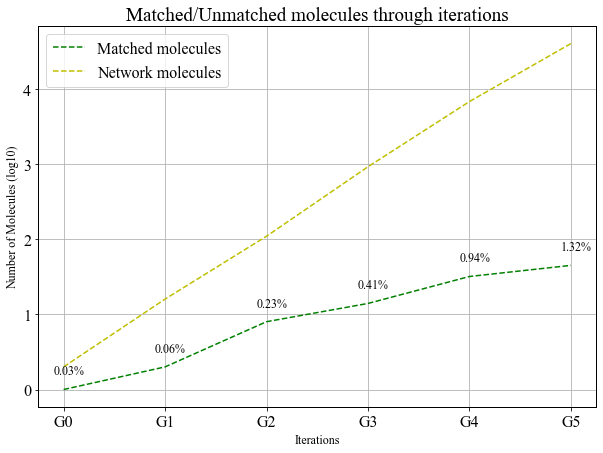

In [8]:
matched,missed,matched_list,unmatched_list = compare_networks_database(Network ,Database,verbose=True)

In [9]:
len(matched_l)

NameError: name 'matched_l' is not defined

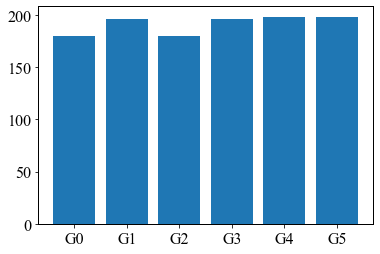

In [22]:
plt.bar(list(MaxMass.keys()),list(MaxMass.values()), width=0.8, bottom=None, align='center')
plt.show()

In [23]:
MaxMass.values()

dict_values([180.156, 196.155, 180.156, 196.155, 198.174, 198.21800000000002])

In [11]:
def DownloadHMDB(Verbose):
    """Downloads an instance of the HMDB.sdf Database if a local copy is not avialble"""
    if Verbose:
        print("Oops, you Don't have a local coppy of HMDB.sdf")
        print("A new instance of the Database will be dowloaded for you")
    url = "https://hmdb.ca/system/downloads/current/structures.zip"
    root = os.getcwd()
    filename = wget.download(url)
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(os.getcwd())
    if Verbose:
        print("Almost Done...")
    os.rename(r'structures.sdf',r'HMDB.sdf')
    os.chdir(root)
    if Verbose:
         print("Done")

In [12]:
DownloadHMDB(Verbose=True)     # Download sdf
  

Oops, you Don't have a local coppy of HMDB.sdf
A new instance of the Database will be dowloaded for you
100% [........................................................................] 48504211 / 48504211Almost Done...


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'structures.sdf' -> 'HMDB.sdf'

In [16]:
path = "HMDB.sdf"
hmdb=Chem.SDMolSupplier(path)  # Load sdf

In [17]:
hmdbsmiles = []
for mol in hmdb:
    try:
        hmdbsmiles.append(Chem.MolToSmiles(mol)) 
    except:
        pass
    

In [18]:
len(hmdbsmiles)

113974

In [19]:
def database_smiles(SMILES,MaxMass,Tautomers=False):
    """ Generates a list that saves smiles strings """
    Ignored = 0
    Network = list()                            # Define an Empty Dictionary
    Limit = max(MaxMass.values())               # Maxmimum molecular weight of network 
    ### Open file with context handler ###
    for smiles in SMILES:                    # Iterate over the lines
        try:
            if Tautomers:
                CanonicalSmiles = get_stable_tatuomer(smiles)
            else:   
                CanonicalSmiles = Chem.CanonSmiles(smiles) # Convert smiles to canonical smiles
            # Check that molecules is not heavier than heavies molecule in network (we will compare apples to apples)
            if MolWt(Chem.MolFromSmiles(CanonicalSmiles)) <= Limit: 
                if re.match("^[CcOoNn]",CanonicalSmiles): # If Molecules starts with C,N,O
                    Network.append(CanonicalSmiles)       # Append molecule to network if mass is lower than limit
            else:
                Ignored +=1 # If not add 1 to ignore counter

        except:
            Ignored +=1   # If there is no canonical smiels, than there must be a typo in string, ingore it 


    print(f"{Ignored} molecules were ignored out of {len(Network)+Ignored}. Leaving a total of  {len(Network)} Molecules.")         
    return Network


In [20]:
Database2 = database_smiles(hmdbsmiles,MaxMass,Tautomers=False)

108617 molecules were ignored out of 113850. Leaving a total of  5233 Molecules.



Summary (Unique Molecules)
---------------------------------------------------------------------------
Iteration G0
Molecules Matches: 1 of total 2, percentage: 50.0 %
Molecules Missed: 1 of total 2 , percent: 50.0 %
---------------------------------------------------------------------------

Iteration G1
Molecules Matches: 1 of total 12, percentage: 8.333333333333332 %
Molecules Missed: 11 of total 12 , percent: 91.66666666666666 %
---------------------------------------------------------------------------

Iteration G2
Molecules Matches: 8 of total 85, percentage: 9.411764705882353 %
Molecules Missed: 77 of total 85 , percent: 90.58823529411765 %
---------------------------------------------------------------------------

Iteration G3
Molecules Matches: 18 of total 718, percentage: 2.5069637883008355 %
Molecules Missed: 700 of total 718 , percent: 97.49303621169916 %
---------------------------------------------------------------------------

Iteration G4
Molecules Matches: 41 of to

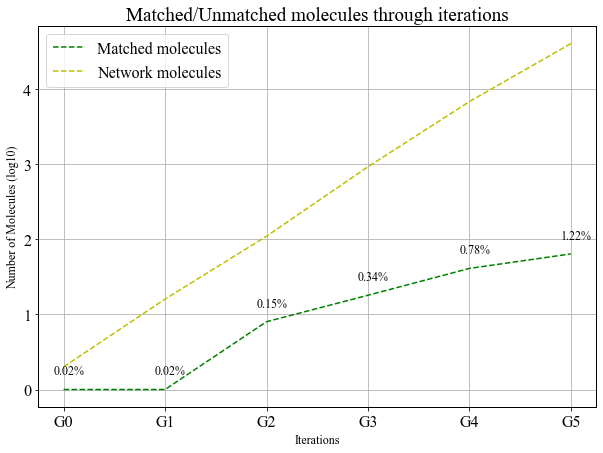

In [21]:
matched,missed,matched_list,unmatched_list = compare_networks_database(Network ,Database2,verbose=True)